In [ ]:
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install plot_keras_history  # Do not use this package to draw diagram

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import

In [ ]:
from __future__ import print_function

import pandas as pd
import numpy as np

from keras import layers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D,Reshape, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate, LSTM, Bidirectional
from keras.models import load_model
from keras.models import Model

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

import matplotlib.pyplot as plt
# from plot_keras_history import plot_history
from tensorflow.keras.utils import plot_model


Using TensorFlow backend.


# ESCONV Classifier - Categories


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_json("ESConv.json")
data.head()
# data.experience_type.value_counts()
display(data.emotion_type.value_counts())
display(data.problem_type.value_counts())

## Label for Classification

In [ ]:
# dict(data.loc[data['problem_type']=='academic pressure', 'problem_type']).keys()

data.loc[data['problem_type']=='School Bullying', 'problem_type'] = "school" #965, 1003
data.loc[data['problem_type']=='academic pressure', 'problem_type'] = "school"

data.loc[data['problem_type']=='problems with friends', 'problem_type'] = "friendship"

data.loc[data['problem_type']=='job crisis', 'problem_type'] = "work"

data.loc[data['problem_type']=='breakup with partner', 'problem_type'] = "relationship"

data.loc[data['problem_type']=='conflict with parents', 'problem_type'] = "family"
data.loc[data['problem_type']=='Issues with Children', 'problem_type'] = "family"
data.loc[data['problem_type']=='Issues with Parents', 'problem_type'] = "family"

data.loc[data['problem_type']=='ongoing depression', 'problem_type'] = "emotional"
data.loc[data['problem_type']=='Appearance Anxiety', 'problem_type'] = "emotional"

data.loc[data['problem_type']=='Sleep Problems', 'problem_type'] = "others"
data.loc[data['problem_type']=='Procrastination', 'problem_type'] = "others"
data.loc[data['problem_type']=='Alcohol Abuse', 'problem_type'] = "others"

display(data.problem_type.value_counts())

labels = set(data.problem_type.values)
labels

In [ ]:
data

In [ ]:
newdata = data[['problem_type', 'situation']]
newdata.to_csv("newdata.csv")


## Classical Machine Learning - NB, DT and SVM Methods

```
[[95  0  0  0  4  0 10]
 [11  0  0  0  0  0  0]
 [27  0 13  0 10  0  4]
 [15  0  0  0  0  0  1]
 [13  0  0  0 58  0  1]
 [19  0  0  0  0 29  2]
 [14  0  0  0  0  2 62]]
NB: 0.658974358974359
```

```
[[67  1  8  2 10  4 17]
 [ 8  0  0  0  1  1  1]
 [ 9  0 41  0  3  0  1]
 [ 4  0  0  8  0  0  4]
 [11  0  7  2 50  1  1]
 [ 5  1  2  3  0 37  2]
 [12  1  0  0  0  2 63]]
DT: 0.6820512820512821
```

```
[[77  0  6  0  8  1 17]
 [ 5  2  1  0  0  1  2]
 [ 4  0 46  0  2  2  0]
 [ 6  0  0  6  0  0  4]
 [ 8  0  6  0 57  0  1]
 [ 7  0  0  0  0 40  3]
 [10  0  2  0  2  2 62]]
SVC: 0.7435897435897436
```

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

newstopwords=stopwords.words("english") + ['the','is','it','may', 'i']
WNlemma = nltk.WordNetLemmatizer()


def pre_process(text):
    tokens = nltk.word_tokenize(text)
    tokens=[WNlemma.lemmatize(t.lower()) for t in tokens]
    tokens=[word for word in tokens if word not in newstopwords]
    text_after_process=" ".join(tokens)
    return(text_after_process)

In [ ]:
#Apply the function on each document
newdata['Text'] = newdata['situation'].apply(pre_process)
newdata.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,problem_type,situation,Text
0,work,I hate my job but I am scared to quit and seek...,hate job scared quit seek new career .
1,friendship,I have complete unsupportive friends its to th...,complete unsupportive friend point dont even f...
2,work,I have been out of work for five weeks in quar...,work five week quarantine due testing positive...
3,emotional,I am depressed staying home due to COVID,depressed staying home due covid
4,relationship,I found out that my boyfriend had been lying t...,"found boyfriend lying entire life , future sai..."


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(newdata.Text, newdata.problem_type, test_size=0.30, random_state=12)

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('vect', CountVectorizer()),   #Vectorizer
                     ('tfidf', TfidfTransformer()), #DTM with TFIDF
                      ('clf', MultinomialNB()),     #ML Model
                    ])

text_clf.fit(X_train,y_train ) 

##Evaluate the model
import numpy as np
from sklearn import metrics 
predicted = text_clf.predict(X_test)
print(metrics.confusion_matrix(y_test, predicted))
print("NB:",np.mean(predicted == y_test) )

[[95  0  0  0  4  0 10]
 [11  0  0  0  0  0  0]
 [27  0 13  0 10  0  4]
 [15  0  0  0  0  0  1]
 [13  0  0  0 58  0  1]
 [19  0  0  0  0 29  2]
 [14  0  0  0  0  2 62]]
NB: 0.658974358974359


In [ ]:
from sklearn import tree
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                      ('clf', tree.DecisionTreeClassifier())
                    ])
clf = text_clf.fit(X_train, y_train) 

predicted = clf.predict(X_test)

print(metrics.confusion_matrix(y_test, predicted))
print("DT:",np.mean(predicted == y_test) )

[[67  1  9  1  9  4 18]
 [ 9  0  0  0  0  1  1]
 [ 8  0 43  0  2  0  1]
 [ 4  0  1  7  0  0  4]
 [16  0  7  1 46  1  1]
 [ 6  0  2  2  0 37  3]
 [16  0  0  0  0  3 59]]
DT: 0.6641025641025641


In [ ]:
from sklearn import svm
from sklearn.svm import SVC

from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer(use_idf=True)),
                      ('clf', svm.LinearSVC(C=1.0))
                    ])
text_clf.fit(X_train, y_train) 
    
predicted = text_clf.predict(X_test)
 
print(metrics.confusion_matrix(y_test, predicted))
print(np.mean(predicted == y_test) )
print(metrics.classification_report(y_test, predicted))

[[77  0  6  0  8  1 17]
 [ 5  2  1  0  0  1  2]
 [ 4  0 46  0  2  2  0]
 [ 6  0  0  6  0  0  4]
 [ 8  0  6  0 57  0  1]
 [ 7  0  0  0  0 40  3]
 [10  0  2  0  2  2 62]]
0.7435897435897436
              precision    recall  f1-score   support

   emotional       0.66      0.71      0.68       109
      family       1.00      0.18      0.31        11
  friendship       0.75      0.85      0.80        54
      others       1.00      0.38      0.55        16
relationship       0.83      0.79      0.81        72
      school       0.87      0.80      0.83        50
        work       0.70      0.79      0.74        78

    accuracy                           0.74       390
   macro avg       0.83      0.64      0.67       390
weighted avg       0.76      0.74      0.74       390



In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-04-11 13:57:58--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-11 13:57:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-11 13:57:59--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


## Data Preprocessing, Tokenization, Padding Sentences, Embedding, One-Hot Encoding

In [ ]:
#Data Preprocessing 
y = data['problem_type']
X = data['situation']
length = data['situation'].apply(len)
data = data.assign(Len_Situation=length)

# Split train & test
text_train, text_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)
X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set
print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

#Padding the sentences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#embedding dimension should align with the GLOVE
embedding_dim = 100
vocab_size = len(word_index) + 1

GLOVE_6B_100D_PATH ="glove.6B.100d.txt"
encoding="utf-8"
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    embeddings_index = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / vocab_size)   

vocabubary size: 2450
max length text: 196
0.9575510204081633


In [ ]:
#create class weight dict for unbanlanced dataset
#If 'balanced', class weights will be given by n_samples / (n_classes * np.bincount(y)

class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
class_weights_d = dict(enumerate(class_weights))

##onehot encoding for y
def categoricalList2Onehot(listOfClasses):
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(listOfClasses)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

y_train_onehot = categoricalList2Onehot(y_train)
print(y_train_onehot.shape)
y_test_onehot = categoricalList2Onehot(y_test)
print(y_test_onehot.shape)

(910, 7)
(390, 7)


In [ ]:
print("Maxlen: ", maxlen)
print("VocabSize: ", vocab_size)
print("embedding_dim: ", embedding_dim)
print("embedding_matrix shape: ", embedding_matrix.shape)
print("categories: ", len(labels))

Maxlen:  196
VocabSize:  2450
embedding_dim:  100
embedding_matrix shape:  (2450, 100)
categories:  7


## Shallow CNN

In [ ]:
# Shallow CNN
shallow_CNN = Sequential()
shallow_CNN.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
shallow_CNN.add(Conv1D(512, 3, activation='relu'))
shallow_CNN.add(GlobalMaxPooling1D())
shallow_CNN.add(Dense(len(labels), activation='softmax'))
shallow_CNN.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
shallow_CNN.summary()

plot_model(shallow_CNN, 
           to_file='./shallow_cnn.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

#train the model
hist_shallow = shallow_CNN.fit(X_train, y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=64).history

loss, accuracy = shallow_CNN.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = shallow_CNN.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_shallow)

In [ ]:
shallow_CNN.save("/content/drive/MyDrive/Colab Notebooks/MTech/S2/PLP_Project/shallowcnn_78_66.h5")

## Shallow with Dropout

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     (None, 196, 100)          245000    
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 194, 512)          154112    
_________________________________________________________________
global_max_pooling1d_34 (Glo (None, 512)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 7)                 455       
Total params: 432,399
Trainable params: 187,399
Non-trainable params: 245,000
_________________________________________

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1df47db250>,
       dtype=object))

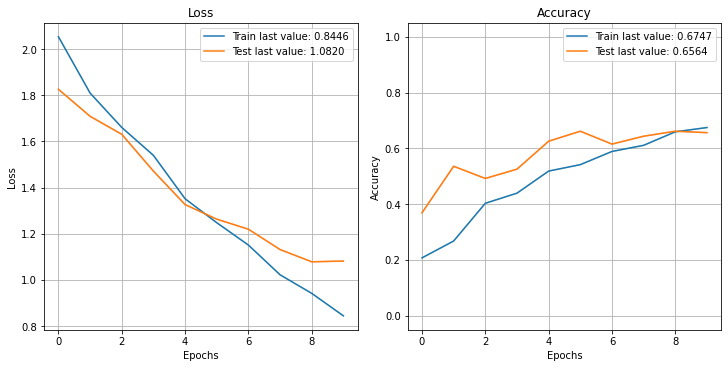

In [ ]:
#Modified Shallow CNN with Dropout
shallow_do = Sequential()
shallow_do.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#trigram. #kernels/filters=512
shallow_do.add(Conv1D(512, 3, activation='relu'))
shallow_do.add(GlobalMaxPooling1D())
shallow_do.add(Dense(64, activation='relu'))
shallow_do.add(Dropout(0.5))
shallow_do.add(Dense(len(labels), activation='softmax'))
shallow_do.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
shallow_do.summary()
plot_model(shallow_do, 
           to_file='./shallow_do.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

#train the model

hist_shallow_do = shallow_do.fit(X_train, y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test_onehot),
                    batch_size=64).history

loss, accuracy = shallow_do.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = shallow_do.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_shallow_do)

In [ ]:
shallow_do.save("/content/drive/MyDrive/Colab Notebooks/MTech/S2/PLP_Project/shallowdo_67_65.h5")

## Deep CNN

In [ ]:
##Deep CNN 
# define the model
from keras.layers.merge import concatenate

def define_model(length, vocab_size,embedding_dim):
	# channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs1)
	conv1 = Conv1D(filters=128, kernel_size=2, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
	# channel 2
	inputs2 = Input(shape=(length,))
	embedding2 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs2)
	conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
	# channel 3
	inputs3 = Input(shape=(length,))
	embedding3 = Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(inputs3)
	conv3 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding3)
	drop3 = Dropout(0.5)(conv3)
	pool3 = MaxPooling1D(pool_size=2)(drop3)
	flat3 = Flatten()(pool3)
	# merge
	merged = concatenate([flat1, flat2, flat3])
	# interpretation
	dense1 = Dense(64, activation='relu')(merged)
	outputs = Dense(len(labels), activation='softmax')(dense1)
	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize
	print(model.summary())
	return model

deep = define_model(maxlen,vocab_size,embedding_dim)
#train the model

plot_model(deep, 
           to_file='./model_deep.png', 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')
hist_deep = deep.fit([X_train,X_train,X_train], y_train_onehot,
                    class_weight = class_weights_d,
                    epochs=20,
                    verbose=True,
                    validation_data=([X_test,X_test,X_test], y_test_onehot),
                    batch_size=64).history


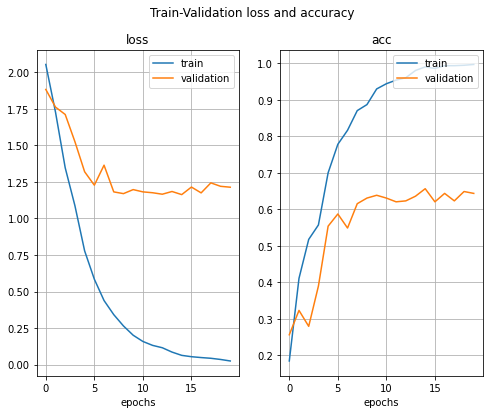

In [ ]:
import matplotlib.pyplot as plt

     
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.plot(hist_deep['loss'],label="train")
plt.plot(hist_deep['val_loss'],label="validation")
plt.title('loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')
plt.grid(hist_deep['loss'])

plt.subplot(1, 2, 2)
plt.plot(hist_deep['accuracy'],label="train")
plt.plot(hist_deep['val_accuracy'],label="validation")
plt.title('acc')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')
plt.grid(hist_deep['loss'])

plt.suptitle("Train-Validation loss and accuracy")

plt.show()

Text(0, 0.5, '')

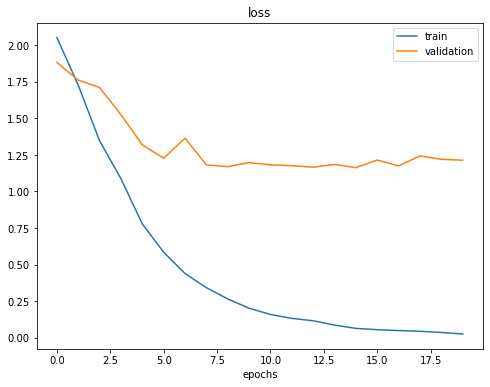

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(hist_deep['loss'],label="train")
plt.plot(hist_deep['val_loss'],label="validation")
plt.title('loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')

Text(0, 0.5, '')

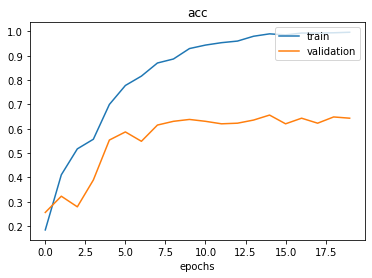

In [ ]:
plt.plot(hist_deep['accuracy'],label="train")
plt.plot(hist_deep['val_accuracy'],label="validation")
plt.title('acc')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')

## BiLSTM - output Dropout

In [ ]:
#Define the BiLSTM model with output Dropout
##############################################
bilstm_out_dp = Sequential()
bilstm_out_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
bilstm_out_dp.add(Bidirectional(LSTM(64)))
#output Dropout
bilstm_out_dp.add(Dropout(0.5))
bilstm_out_dp.add(Dense(len(labels), activation='softmax'))

# try using different optimizers and different optimizer configs
bilstm_out_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
bilstm_out_dp.summary()

#Train the model
batch_size = 64

print('Train...')
hist_bilstm_out_dp = bilstm_out_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=20,
          validation_data=[X_test, y_test_onehot]).history

# loss, accuracy = bilstm_out_dp.evaluate(X_train, y_train_onehot, verbose=True)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = bilstm_out_dp.evaluate(X_test, y_test_onehot, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))
# plot_history(hist_bilstm_out_dp)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 196, 100)          245000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 903       
Total params: 330,383
Trainable params: 85,383
Non-trainable params: 245,000
_________________________________________________________________
Train...
Train on 910 samples, validate on 390 samples
Epoch 1/20
910/910 [==============================] - 9s 10ms/step - loss: 1.8406 - accuracy: 0.2516 - val_loss: 1.7087 - val_accuracy: 0.3128
Epoch 2/20
910/910 [=======================

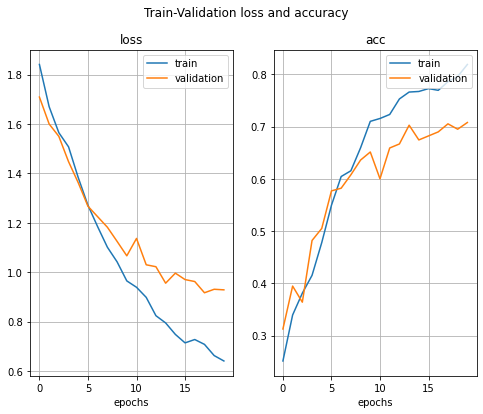

In [ ]:
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.plot(hist_bilstm_out_dp['loss'],label="train")
plt.plot(hist_bilstm_out_dp['val_loss'],label="validation")
plt.title('loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')
plt.grid(hist_bilstm_out_dp['loss'])

plt.subplot(1, 2, 2)
plt.plot(hist_bilstm_out_dp['accuracy'],label="train")
plt.plot(hist_bilstm_out_dp['val_accuracy'],label="validation")
plt.title('acc')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')
plt.grid(hist_bilstm_out_dp['loss'])

plt.suptitle("Train-Validation loss and accuracy")

plt.show()

## BiLSTM - Input Dropout

In [ ]:
#Input Layer Dropout. 
###############################################################################
bilstm_in_dp = Sequential()
bilstm_in_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout
bilstm_in_dp.add(Bidirectional(LSTM(64,dropout=0.5)))
bilstm_in_dp.add(Dense(len(labels), activation='softmax'))
# try using different optimizers and different optimizer configs
bilstm_in_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
bilstm_in_dp.summary()

#Train the model
batch_size = 64

print('Train...')
hist_bilstm_in_dp = bilstm_in_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=20,
          validation_data=[X_test, y_test_onehot]).history

# loss, accuracy = bilstm_in_dp.evaluate(X_train, y_train_onehot, verbose=True)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = bilstm_in_dp.evaluate(X_test, y_test_onehot, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))
# plot_history(hist_bilstm_in_dp)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 196, 100)          245000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 903       
Total params: 330,383
Trainable params: 85,383
Non-trainable params: 245,000
_________________________________________________________________
Train...
Train on 910 samples, validate on 390 samples
Epoch 1/20
910/910 [==============================] - 7s 8ms/step - loss: 1.8011 - accuracy: 0.2538 - val_loss: 1.7186 - val_accuracy: 0.3051
Epoch 2/20
910/910 [==============================] - 6s 7ms/step - loss: 1.6916 - accuracy: 0.3451 - val_loss: 1.6753 - val_accuracy: 0.4179
Epoch 3/20
910/910 [==============

In [ ]:
hist = hist_bilstm_in_dp

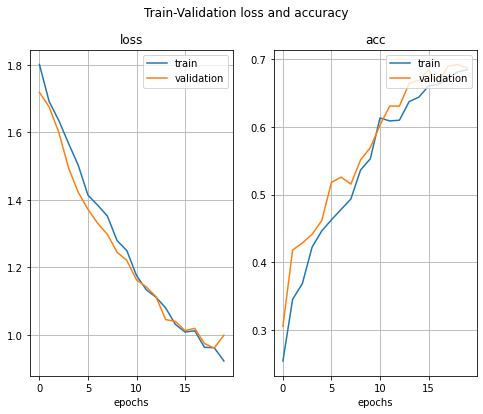

In [ ]:
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'],label="train")
plt.plot(hist['val_loss'],label="validation")
plt.title('loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')
plt.grid(hist['loss'])

plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'],label="train")
plt.plot(hist['val_accuracy'],label="validation")
plt.title('acc')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')
plt.grid(hist['loss'])

plt.suptitle("Train-Validation loss and accuracy")

plt.show()

## BiLSTM - Recurrent Dropout

In [ ]:
bilstm_rec_dp.save("/content/drive/MyDrive/Colab Notebooks/MTech/S2/PLP_Project/bilstm_recdp20_78_71.h5")

In [ ]:
#recurent_dropout
###############################################################################
bilstm_rec_dp = Sequential()
bilstm_rec_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#recurent_dropout
bilstm_rec_dp.add(Bidirectional(LSTM(64,recurrent_dropout=0.5)))
bilstm_rec_dp.add(Dense(len(labels), activation='softmax'))

# try using different optimizers and different optimizer configs
bilstm_rec_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
bilstm_rec_dp.summary()
#Train the model
batch_size = 64

print('Train...')
hist_bilstm_rec_dp = bilstm_rec_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=20,
          validation_data=[X_test, y_test_onehot]).history

hist = hist_bilstm_rec_dp

# loss, accuracy = bilstm_rec_dp.evaluate(X_train, y_train_onehot, verbose=True)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = bilstm_rec_dp.evaluate(X_test, y_test_onehot, verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))
# plot_history(hist_bilstm_rec_dp)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 196, 100)          245000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 903       
Total params: 330,383
Trainable params: 85,383
Non-trainable params: 245,000
_________________________________________________________________
Train...
Train on 910 samples, validate on 390 samples
Epoch 1/20
910/910 [==============================] - 9s 10ms/step - loss: 1.7959 - accuracy: 0.2571 - val_loss: 1.6991 - val_accuracy: 0.2872
Epoch 2/20
910/910 [==============================] - 11s 12ms/step - loss: 1.6558 - accuracy: 0.3341 - val_loss: 1.6239 - val_accuracy: 0.4256
Epoch 3/20
910/910 [===========

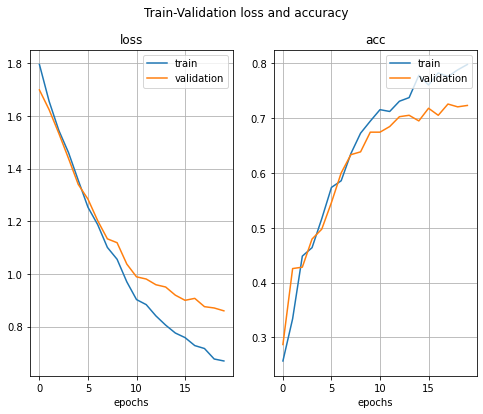

In [ ]:
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'],label="train")
plt.plot(hist['val_loss'],label="validation")
plt.title('loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')
plt.grid(hist['loss'])

plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'],label="train")
plt.plot(hist['val_accuracy'],label="validation")
plt.title('acc')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')
plt.grid(hist['loss'])

plt.suptitle("Train-Validation loss and accuracy")

plt.show()

In [ ]:
#Combain all dropout
##############################################################################
bilstm_all_dp = Sequential()
bilstm_all_dp.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
#Input Dropout and rec Dropout
bilstm_all_dp.add(Bidirectional(LSTM(64,dropout=0.5,recurrent_dropout=0.5)))
#output Dropout
bilstm_all_dp.add(Dropout(0.5))
bilstm_all_dp.add(Dense(len(labels), activation='softmax'))
# try using different optimizers and different optimizer configs
bilstm_all_dp.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
bilstm_all_dp.summary()

#Train the model
batch_size = 64

print('Train...')
hist_bilstm_all_dp = bilstm_all_dp.fit(X_train, y_train_onehot,
          batch_size=batch_size,
          epochs=20,
          validation_data=[X_test, y_test_onehot]).history
hist = hist_bilstm_all_dp
# loss, accuracy = bilstm_all_dp.evaluate(X_train, y_train_onehot, verbose=True)
# print("Training Accuracy: {:.4f}".format(accuracy))
# loss, accuracy = bilstm_all_dp.evaluate(X_test, y_test_onehot, verbose=False)
# print("Validatio Accuracy:  {:.4f}".format(accuracy))
# plot_history(hist_bilstm_all_dp)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 196, 100)          245000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 903       
Total params: 330,383
Trainable params: 85,383
Non-trainable params: 245,000
_________________________________________________________________
Train...
Train on 910 samples, validate on 390 samples
Epoch 1/20
910/910 [==============================] - 7s 8ms/step - loss: 1.8858 - accuracy: 0.2275 - val_loss: 1.7232 - val_accuracy: 0.3615
Epoch 2/20
910/910 [========================

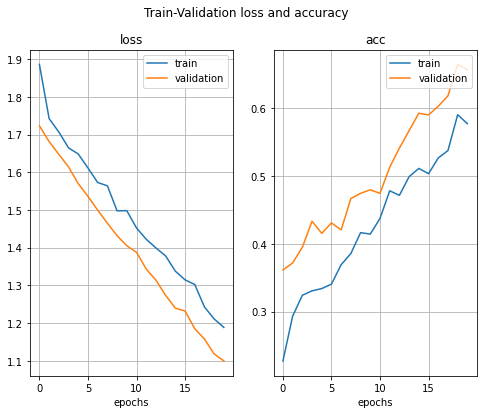

In [ ]:
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'],label="train")
plt.plot(hist['val_loss'],label="validation")
plt.title('loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')
plt.grid(hist['loss'])

plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'],label="train")
plt.plot(hist['val_accuracy'],label="validation")
plt.title('acc')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('')
plt.grid(hist['loss'])

plt.suptitle("Train-Validation loss and accuracy")

plt.show()

## Compare all models

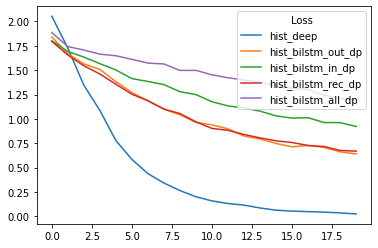

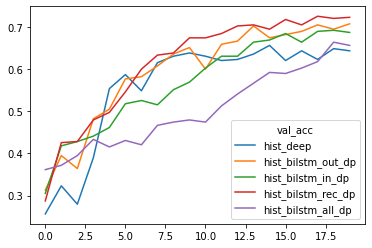

In [ ]:
#Compare all the models
import matplotlib.pyplot as plt

# # plt.plot(hist_shallow['loss'], label='hist_shallow')
# plt.plot(hist_shallow_do['loss'], label='hist_shallow_do')
plt.plot(hist_deep['loss'], label='hist_deep')
plt.plot(hist_bilstm_out_dp['loss'], label='hist_bilstm_out_dp')
plt.plot(hist_bilstm_in_dp['loss'], label='hist_bilstm_in_dp')
plt.plot(hist_bilstm_rec_dp['loss'], label='hist_bilstm_rec_dp')
plt.plot(hist_bilstm_all_dp['loss'], label='hist_bilstm_all_dp')
plt.legend(loc='upper right', title="Loss")
plt.show()

# plt.plot(hist_shallow['val_accuracy'], label='hist_shallow')
# plt.plot(hist_shallow_do['val_accuracy'], label='hist_shallow_do')
plt.plot(hist_deep['val_accuracy'], label='hist_deep')
plt.plot(hist_bilstm_out_dp['val_accuracy'], label='hist_bilstm_out_dp')
plt.plot(hist_bilstm_in_dp['val_accuracy'], label='hist_bilstm_in_dp')
plt.plot(hist_bilstm_rec_dp['val_accuracy'], label='hist_bilstm_rec_dp')
plt.plot(hist_bilstm_all_dp['val_accuracy'], label='hist_bilstm_all_dp')
plt.legend(loc='lower right', title = 'val_acc')
plt.show()